## このノートブックでは、提出用のシンプルなベースラインを作成し、今後詳しく分析するために重要な特徴量を特定します。

In [1]:
# 必要なライブラリの読み込み
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import seaborn as sns

import gc

import warnings
warnings.filterwarnings("ignore")

In [2]:
# データディレクトリの設定
ROOT_DIR = "/home/datasets/"

In [3]:
# データの読み込み
train_df = pd.read_csv(f"{ROOT_DIR}/train.csv")
test_df = pd.read_csv(f"{ROOT_DIR}/test.csv")

In [4]:
train_df.shape,  test_df.shape

((363924, 149), (112437, 149))

In [5]:
set(train_df.columns) - set(test_df.columns)

{'money_room'}

In [6]:
set(test_df.columns)- set(train_df.columns) 

{'id'}

 ###  money_roomが目的変数で、'id'列は識別子です。その他の列は両方のデータセットで同じです。

In [7]:
train_money_room = train_df.money_room.values
test_id = test_df['id']

train_df.drop(['money_room'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)


# 基本的なEDA

In [8]:
# 目的変数を見てみましょう

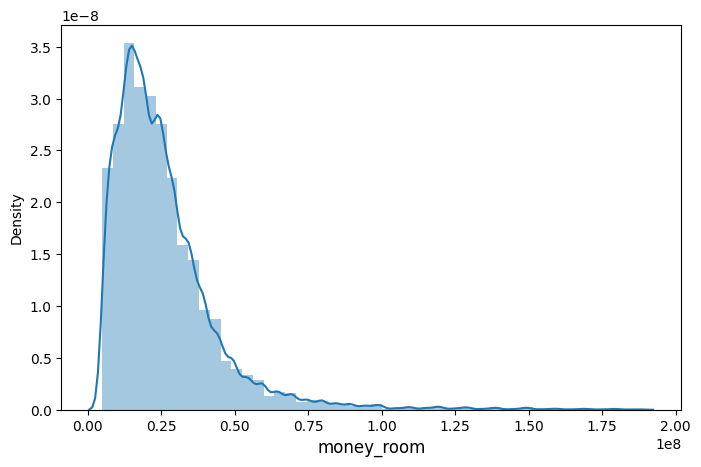

In [9]:
plt.figure(figsize=(8,5))
sns.distplot(train_money_room, bins=50, kde=True)
plt.xlabel('money_room', fontsize=12)
plt.show()

###  データは非常に長い右裾を持っています。これは問題になる可能性があります。money_room変数の対数をプロットしてみましょう。

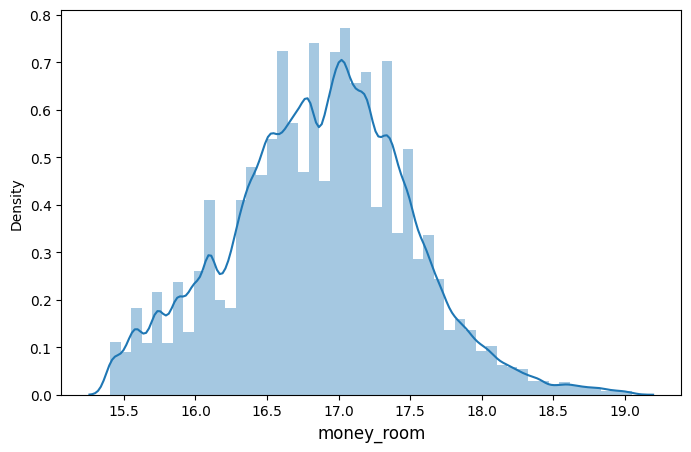

In [10]:
plt.figure(figsize=(8,5))
sns.distplot(np.log1p(train_money_room), bins=50, kde=True)
plt.xlabel('money_room', fontsize=12)
plt.show()

### これは正規分布のように見えます。

README.pdf によると、**学習データとテストデータは掲載時期が異なります**。 

> 学習用データ：2019〜2022年の 1月または 7月  
> テストデータ：2023年の 1月または 7月

これを確認してみましょう。

In [11]:
train_df["target_ym"].max(), test_df["target_ym"].min()

(202207, 202301)

### 学習データとテストデータが異なる時期のものだと確認できました。

## 欠損データ

In [12]:
def get_missing_report(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df = missing_df.loc[missing_df['missing_count']>0]
    missing_df["missing_ratio"] = missing_df["missing_count"]/len(df)
    
    return missing_df

In [13]:
train_missing = get_missing_report(train_df)
test_missing = get_missing_report(test_df)

In [14]:
train_missing

,column_name,missing_count,missing_ratio
6,building_name,164886,0.453078
7,building_name_ruby,363924,1.000000
8,homes_building_name,25994,0.071427
9,homes_building_name_ruby,260019,0.714487
10,unit_count,136003,0.373713
...,...,...,...
143,statuses,12590,0.034595
144,parking_keiyaku,356329,0.979130
145,money_hoshou_company,363924,1.000000
146,free_rent_duration,363924,1.000000


### 欠損値を持つ列が多数あり、中には完全に空のものもあります。今後処理する必要があります。

In [15]:
train_missing[train_missing.missing_ratio==1]

,column_name,missing_count,missing_ratio
7,building_name_ruby,363924,1.0
46,name_ruby,363924,1.0
130,school_ele_code,363924,1.0
133,school_jun_code,363924,1.0
145,money_hoshou_company,363924,1.0
146,free_rent_duration,363924,1.0
147,free_rent_gen_timing,363924,1.0


In [16]:
# remove them from train and test
drop_cols = train_missing[train_missing.missing_ratio==1].column_name
train_df.drop(drop_cols, axis=1, inplace=True)
test_df.drop(drop_cols, axis=1, inplace=True)

# 基本的な前処理

###  'addr1_1'と'addr1_2'を実際の都道府県名と市区町村名に置き換えて、直感的に理解できるようにします

In [17]:
data_definition = pd.ExcelFile(f"{ROOT_DIR}/data_definition.xlsx")

In [18]:
train_df[['addr1_1', 'addr1_2']].sample(3, random_state=2025)

,addr1_1,addr1_2
48171,11,201
16175,27,147
286956,1,106


In [19]:
# data_definition.sheet_names
codes = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[3])
codes.columns = ['No.', 'addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']
codes = codes[['addr1_1', 'addr1_2', 'Prefecture name',
       'City/town/village name']]

train_df = pd.merge(train_df, codes, on=['addr1_1', 'addr1_2'], how='inner')
test_df = pd.merge(test_df, codes, on=['addr1_1', 'addr1_2'], how='inner')

In [20]:
train_df.drop(['addr1_1', 'addr1_2'], axis=1, inplace=True)
test_df.drop(['addr1_1', 'addr1_2'], axis=1, inplace=True)
del codes

In [21]:
train_df[['Prefecture name', 'City/town/village name']].sample(3, random_state=2025)

,Prefecture name,City/town/village name
48171,埼玉県,川越市
16175,大阪府,堺市美原区
286956,北海道,札幌市南区


## 特徴量抽出
data_definition.xlsx を確認すると、以下のカラムにはスラッシュ区切りで複数の値が格納されており、展開が必要です：
"building_tag_id", "unit_tag_id",
"reform_interior", "reform_exterior", "reform_wet_area",
"statuses"


In [22]:
train_df["building_tag_id"].sample(3)

10436                             NaN
128633    210101/210301/320901/210201
287683                  210301/210101
Name: building_tag_id, dtype: object

### これらの列を展開し、それに基づいて新たな特徴量を作成します。また、可読性を高めるために、タグIDを対応するタグ内容に置き換えます。

In [23]:
tag_master = pd.read_excel(f"{ROOT_DIR}/data_definition.xlsx", sheet_name=data_definition.sheet_names[2])
tag_master = tag_master[['タグID', 'タグ内容']]
tag_master["タグID"] = tag_master["タグID"].astype("str")
tag_master.set_index('タグID', inplace=True)
tag_master = tag_master.to_dict()['タグ内容']

タグIDから内容へのマッピング辞書を作成しました。次のようになります
```
{'210101': '公営水道',
 '210102': '井戸',
 ...
 '210199': '水道その他'}
```

## スラッシュ区切りの列を展開

In [24]:
slashed_columns = ["building_tag_id", "unit_tag_id", 
                   "reform_interior",  "reform_exterior","reform_wet_area",
                  "statuses"]

In [25]:
def get_slashed_tags(df):
    """スラッシュ区切りの値を持つ列を個別の列に変換する"""
    temp_dfs = []
    for col in slashed_columns:
        # 列を分割
        temp_df = df[col].str.get_dummies(sep="/").astype("str")
        # タグIDをタグ内容に置き換え
        temp_df.rename(columns=tag_master, inplace=True)
        # 後で識別できるように元の列名を追加
        new_col_name = [f"{col} " + c for c in temp_df.columns]
        temp_df.columns = new_col_name
        temp_dfs.append(temp_df)
    temp_dfs = pd.concat(temp_dfs, axis=1)
    return temp_dfs

### train_dfとtest_dfで個別に実行できますが、`pandas get_dummies` を使用しているため、testとtrainのデータフレームで列数が一致しない可能性があります。そこで、結合 -> 列を展開 -> 再度分割します。

## スラッシュ区切りの列を取得
この処理には約**1分ほど**かかります。

In [26]:
combined_df = pd.concat([train_df, test_df])
slashed_df = get_slashed_tags(combined_df)

In [27]:
slashed_df.head()

,building_tag_id 楽器相談,building_tag_id 楽器不可,building_tag_id セキュリティ会社加入済み,building_tag_id 公営水道,building_tag_id 井戸,building_tag_id 水道その他,building_tag_id 都市ガス,building_tag_id プロパンガス,building_tag_id ガスその他,building_tag_id 下水,...,statuses 新築時・増改築時の設計図書,statuses 修繕・点検の記録,statuses 336401,statuses BELS/省エネ基準適合認定建築物,statuses 1階の物件,statuses 2階以上,statuses 最上階,statuses 角地,statuses 角部屋,statuses 350201
0,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


### 374列を追加作成しました。これらを結合データフレームに追加し、元の列を削除します。

In [28]:
# 新しく生成された列名を保存
tag_columns = slashed_df.columns
# 抽出した特徴量を結合
combined_df = pd.concat([combined_df, slashed_df], axis=1)
# スラッシュ区切りの列を削除
combined_df.drop(slashed_columns, axis=1, inplace=True)
# trainとtestに分割
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

In [29]:
del slashed_df
gc.collect()

121

In [30]:
train_df.shape, test_df.shape

((363924, 509), (112437, 509))

## 築年を処理し、年のみを保持

In [31]:
def parse_year(date_input):
    try:
        date_input = str(date_input)
        return date_input[:4]           
    except Exception as e:
        return str(date_input)

In [32]:
train_df["year_built"].sample(3)

166254    200008.0
137010    200111.0
223927    201802.0
Name: year_built, dtype: float64

In [33]:
train_df["year_built"] = train_df["year_built"].apply(parse_year)
test_df["year_built"] = test_df["year_built"].apply(parse_year)

In [34]:
train_df["year_built"].sample(3)

27225    2009
2185     1979
68813    2006
Name: year_built, dtype: object

In [35]:
numerical_columns = [
    "unit_count",
    "lon",
    "lat",
    "total_floor_area",
    "building_area",
    "floor_count",
    "basement_floor_count",
    "building_land_area",
    "land_area_all",
    "unit_area_min",
    "unit_area_max",
    "land_setback",
    "land_kenpei",
    "land_youseki",
    "room_floor",
    "balcony_area",
    "room_count",
    "unit_area",
    "empty_number",
    "nl",
    "el",
    "bus_time1",
    "walk_distance1",
    "bus_time2",
    "walk_distance2",
    "traffic_car",
    "snapshot_land_area",
    "snapshot_land_shidou",
    "land_shidou_a",
    "land_shidou_b",
    "land_mochibun_a",
    "land_mochibun_b",
    "house_area",
    "room_kaisuu",
    "madori_number_all",
    "money_kyoueki",
    "money_rimawari_now",
    "money_shuuzen",
    "money_shuuzenkikin",
    "money_sonota1",
    "money_sonota2",
    "money_sonota3",
    "parking_money",
    "parking_distance",
    "parking_number",
    "school_ele_distance",
    "school_jun_distance",
    "convenience_distance",
    "super_distance",
    "hospital_distance",
    "park_distance",
    "drugstore_distance",
    "bank_distance",
    "shopping_street_distance",
    "est_other_distance",
]


### カテゴリカル列の中には、int, float, stringなど混在したデータ型があります. 簡潔にするために、すべて文字列に変換します

In [36]:
categorical_cols = [c for c in train_df.columns if c not in numerical_columns]

In [37]:
cat_col_fix = list(set(categorical_cols) - set(tag_columns))

In [38]:
def convert_cat(cat_val):
    try:
        return str(int(eval(cat_val)))
    except:
        try:
            return str(int(cat_val))
        except:
            return str(cat_val)

In [39]:
train_df[cat_col_fix] = train_df[cat_col_fix].applymap(convert_cat)
test_df[cat_col_fix] = test_df[cat_col_fix].applymap(convert_cat)

In [40]:
len(categorical_cols)

454

## シンプルなモデルの構築  

In [41]:
train_y = np.log1p(train_money_room)

In [42]:
params = {
    "loss_function" : "MAE",
    "task_type":  "GPU",  # CPUで実行する場合はこれを削除
    "random_seed": 2025,
    "verbose": 1000,
    "iterations": 5000
    
}

In [43]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(**params) 
model.fit(train_df, train_y, cat_features=categorical_cols)

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.4906493	total: 44.6ms	remaining: 3m 43s
1000:	learn: 0.1680733	total: 39.4s	remaining: 2m 37s
2000:	learn: 0.1543189	total: 1m 18s	remaining: 1m 57s
3000:	learn: 0.1470533	total: 1m 57s	remaining: 1m 17s
4000:	learn: 0.1421219	total: 2m 35s	remaining: 38.9s
4999:	learn: 0.1382865	total: 3m 13s	remaining: 0us


In [44]:
train_pred = np.expm1(model.predict(train_df))

In [45]:
from sklearn.metrics import mean_absolute_percentage_error
mape_error = mean_absolute_percentage_error(train_money_room, train_pred)
print("MAPE Error ", mape_error)

MAPE Error  0.13126594481553186


In [46]:
feature_importance = pd.DataFrame({'feature_name': train_df.columns,
                            'importance': model.get_feature_importance()})

In [47]:
feature_importance = feature_importance[feature_importance["importance"]>0]

In [48]:
#  今後の分析のために保存します。
feature_importance.to_csv("feature_importance.csv", index=False)

In [49]:
feature_importance.sort_values("importance", ascending=False)[:20]

,feature_name,importance
92,house_area,13.976670
18,year_built,12.145137
134,City/town/village name,8.935511
10,full_address,5.211523
98,madori_kind_all,4.587941
3,building_create_date,3.457771
86,snapshot_land_area,2.820824
75,eki_name1,2.511949
68,post1,2.427292
78,walk_distance1,2.185876


# 提出用ファイルを作成する

In [50]:
test_pred = model.predict(test_df)
test_pred = np.expm1(test_pred)

In [51]:
submit_df = pd.DataFrame({"id": test_id, "money_room":test_pred})

In [52]:
submit_df.head(2)

,id,money_room
0,0,1.411234e+07
1,1,2.052801e+07


In [53]:
submit_df.to_csv("sample_submit.csv", index=False, header=False)